In [1]:
# connexion a wrds 
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [84]:
# IMPORTS
import wrds
import pandas as pd
import numpy as np
import os

np.random.seed(42)  # reproductibilité globale


# --- Connexion WRDS ---
def connect_wrds():
    print(">>> Connexion WRDS...")
    db = wrds.Connection()
    print(">>> Connexion WRDS OK.\n")
    return db


# --- Échantillon reproductible de 50 tickers du S&P500 ---
def get_sp500_sample(df, db, rebuild_cache=False):
    """
    Retourne un échantillon stable de 50 tickers du S&P500 avec EPS.
    Cache local : valid_tickers.npy + sample_tickers.npy
    """
    np.random.seed(42)

    # tri pour stabilité
    unique_tickers = sorted(df["ticker"].dropna().unique())

    # 1) Charger valid_tickers à partir du cache ou les reconstruire
    if os.path.exists("valid_tickers.npy") and not rebuild_cache:
        valid_tickers = np.load("valid_tickers.npy")
        print(f">>> valid_tickers chargé depuis cache ({len(valid_tickers)} tickers)")
    else:
        print(">>> Recalcul liste des tickers valides EPS...")
        valid_tickers = []
        for ticker in unique_tickers:
            query = f"""
                SELECT 1
                FROM comp.fundq
                WHERE tic = '{ticker}'
                LIMIT 1
            """
            result = db.raw_sql(query)
            if not result.empty:
                valid_tickers.append(ticker)

        np.save("valid_tickers.npy", np.array(valid_tickers))
        print(f">>> Liste valid_tickers sauvegardée dans valid_tickers.npy ({len(valid_tickers)} tickers)\n")

    # 2) Charger sample final depuis cache ou recréer
    if os.path.exists("sample_tickers.npy") and not rebuild_cache:
        sample_tickers = np.load("sample_tickers.npy")
        print(f">>> sample_tickers chargé depuis cache ({len(sample_tickers)} tickers)")
    else:
        print(">>> Génération échantillon stable de 50 tickers...")
        sample_tickers = np.random.choice(valid_tickers, size=50, replace=False)
        np.save("sample_tickers.npy", sample_tickers)
        print(">>> sample_tickers sauvegardé dans sample_tickers.npy\n")

    # construire le dataframe
    sample = df[df["ticker"].isin(sample_tickers)][["permno", "ticker"]].drop_duplicates()
    print(f">>> Échantillon final : {len(sample['ticker'].unique())} tickers sélectionnés.\n")
    return sample


# --- Extraction CRSP
def get_prices(db, sample):
    permno_list = "', '".join(sample['permno'].astype(str).unique())
    query = f"""
        SELECT date, prc, permno
        FROM crsp.dsf
        WHERE permno IN ('{permno_list}')
        ORDER BY permno, date
    """
    prices = db.raw_sql(query)
    print(">>> Prix téléchargés.\n")
    return prices


# --- Extraction EPS
def get_eps(db, sample):
    tic_list = "', '".join(sample['ticker'].unique())
    query = f"""
        SELECT gvkey, tic AS ticker, datadate, epspxq
        FROM comp.fundq
        WHERE tic IN ('{tic_list}')
        ORDER BY gvkey, datadate
    """
    eps = db.raw_sql(query)
    print(">>> EPS téléchargés.\n")
    return eps


# --- Jointure
def merge_prices_eps(prices, eps, sample):
    merged = prices.merge(sample, on='permno', how='left')
    merged = merged.merge(eps, on='ticker', how='left')
    merged = merged[merged['datadate'] <= merged['date']]
    print(">>> Jointure CRSP + EPS effectuée.\n")
    return merged


# --- Calcul Trailing P/E
def compute_trailing_PE(merged):
    merged = merged.sort_values(['permno', 'date'])
    merged['eps_ttm'] = merged.groupby('permno')['epspxq'].rolling(4).sum().reset_index(level=0, drop=True)
    merged['eps_ttm'] = merged.groupby('permno')['eps_ttm'].ffill()
    merged['trailing_pe'] = merged['prc'] / merged['eps_ttm']
    print(">>> Trailing EPS & P/E calculés.\n")
    return merged


# --- Pipeline complet
def run_pipeline(rebuild_cache=False):
    db = connect_wrds()

    df = db.raw_sql("""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE shrcd IN (10,11)
        AND exchcd IN (1,2,3)
    """)

    sample = get_sp500_sample(df, db, rebuild_cache)
    prices = get_prices(db, sample)
    eps = get_eps(db, sample)
    merged = merge_prices_eps(prices, eps, sample)
    final = compute_trailing_PE(merged)

    final['date'] = pd.to_datetime(final['date'])
    final = final[final['date'] > "2003-01-01"]

    print(final.head())
    return final


# --- Run
if __name__ == "__main__":
    final_df = run_pipeline(rebuild_cache=False)
    final_df.to_csv("SP500_trailing_PE.csv", index=False)
    print(">>> Pipeline terminé, CSV sauvegardé.\n")


>>> Connexion WRDS...
WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
>>> Connexion WRDS OK.

>>> valid_tickers chargé depuis cache (13486 tickers)
>>> sample_tickers chargé depuis cache (50 tickers)
>>> Échantillon final : 50 tickers sélectionnés.

>>> Prix téléchargés.

>>> EPS téléchargés.

>>> Jointure CRSP + EPS effectuée.

>>> Trailing EPS & P/E calculés.

             date   prc  permno ticker   gvkey    datadate  epspxq  eps_ttm  \
552005 2003-01-02  <NA>   10066   ABMC  021136  1995-07-31    <NA>     -0.1   
552006 2003-01-02  <NA>   10066   ABMC  021136  1995-10-31    <NA>     -0.1   
552007 2003-01-02  <NA>   10066   ABMC  021136  1996-01-31    <NA>     -0.1   
552008 2003-01-02  <NA>   10066   ABMC  021136  1996-04-30   -0.08     -0.1   
552009 2003-01-02 

In [85]:
final_df.ticker.unique()

<StringArray>
['ABMC', 'MRGO',  'KOS', 'SUPN',  'CPS', 'SHSP', 'VBTX', 'OCGN', 'LNTH',
 'MIII', 'YUMC', 'ONCR', 'VSEE',  'EAS',  'ILA', 'CNVR',  'SKY', 'MCHT',
 'HLIX', 'FSTP', 'MRVC',  'ATN', 'ATRM', 'SMCO', 'AMXC', 'WIRX', 'AHLS',
  'GPI',  'FCS', 'IWOV', 'SWBD', 'FUSB', 'BLDR', 'OBAF']
Length: 34, dtype: string

### Nettoyage et préparation des données

1. **Renommer les colonnes** pour plus de clarté : `prc → prix`, `epspxq → EPS`, `eps_ttm → EPS_MOBILE`, `trailing_pe → Prix_bene`.

2. **Trier et convertir les dates** par entreprise (`permno`) et date, supprimer colonnes temporaires inutiles.

3. **Filtrer les anciennes données** : garder uniquement les EPS à partir de 2003.

4. **Remplir les valeurs manquantes** (NaN) par forward/backfill par entreprise et supprimer les tickers avec >30% de NaN.

5. **Convertir en float** les colonnes `prix` et `EPS`.

6. **Supprimer doublons** par ticker et date, garder la dernière ligne.

7. **Préparer les données trimestrielles** : garder `permno`, `datadate`, `epspxq`, une seule ligne par trimestre et par entreprise.

8. **Calculer le BPA glissant sur 4 trimestres** (`EPS_MA4`) en moyenne des 4 derniers trimestres pour chaque entreprise.

9. **Fusionner les données journalières et trimestrielles** : associer à chaque ligne quotidienne le BPA glissant du dernier trimestre disponible (`merge_asof` avec `by='permno'`).

10. **Calculer les ratios prix/BPA** :  
    - Historique : `prix / EPS`  
    - Glissant : `prix / EPS_MA4`


In [54]:
# nettoyage et préparations des données 
def nettoyage_df(df):
    
    # par convention on prend la valeur des prix en absolue
    df['prc'] = df['prc'].abs()

    # par convention on prend la valeur des prix en absolue
    final_df['prc'] = final_df['prc'].abs()

    # Renommer les colonnes proprement
    df = df.rename(columns={
        "prc": "prix",
        "epspxq": "EPS",
        "eps_ttm": "EPS_MOBILE",
        "trailing_pe": "Prix_bene"
    })
    
    # Trier les données par entreprise et par date
    df = df.sort_values(['permno', 'date'])
    
    # Supprimer les colonnes temporaires
    df = df.drop(columns=['EPS_MOBILE', 'Prix_bene'])
    
    # Convertir les dates
    df['date'] = pd.to_datetime(df['date'])
    df['datadate'] = pd.to_datetime(df['datadate'])
    
    # Filtrer les EPS trop anciens : garder EPS >= 2003
    df = df[df['datadate'] >= "2003-01-01"]
    
    # Remplir les NaN dans EPS par forward-fill + backfill par permno
    df['EPS'] = df.groupby('permno')['EPS'].transform(lambda x: x.ffill().bfill())
    
    # Garder uniquement les tickers avec moins de 30% de NaN sur EPS
    nan_eps_pct = df.groupby('ticker')['EPS'].apply(lambda x: x.isna().mean())
    tickers_valides = nan_eps_pct[nan_eps_pct <= 0.30].index
    df = df[df['ticker'].isin(tickers_valides)]
    
    # Convertir les colonnes en float
    float_cols = ['prix', 'EPS']
    for col in float_cols:
        df[col] = pd.to_numeric(df[col])
    
    # Vérifier le type des colonnes
    print("Types de données :\n", df.dtypes)
    
    # Trier par ticker et date pour cohérence
    df = df.sort_values(['permno', 'date'], ascending=True).reset_index(drop=True)
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')
    
    # défintion de df quarter 
    df_quarter = final_df[['permno', 'datadate', 'epspxq', "prc"]].dropna()

    # Convertir datadate en datetime si ce n’est pas déjà le cas
    df_quarter['datadate'] = pd.to_datetime(df_quarter['datadate'])

    # Garder une seule ligne par permno et trimestre
    df_quarter = df_quarter.sort_values(['permno', 'datadate'])
    df_quarter = df_quarter.drop_duplicates(subset=['permno', 'datadate'], keep='first')

    #  Calcul EPS mobile 4 trimestres
    df_quarter['EPS_MA4'] = (
        df_quarter
        .groupby('permno')['epspxq']
        .rolling(window=4, min_periods=4)
        .mean()
        .reset_index(level=0, drop=True)
    )

    # Trier globalement par date pour deux df
    df = df.sort_values('date').reset_index(drop=True)
    df_quarter = df_quarter.sort_values('datadate').reset_index(drop=True)

    #  Calcul prix mobile 4 trimestres
    df_quarter['prix_MA4'] = (
        df_quarter
        .groupby('permno')['prc']
        .rolling(window=4, min_periods=4)
        .mean()
        .reset_index(level=0, drop=True)
    )

    #  Merge des deux df
    df = pd.merge_asof(
        df,
        df_quarter[['permno', 'datadate', 'EPS_MA4', "prix_MA4"]],
        left_on='date',
        right_on='datadate',
        by='permno',
        direction='backward'
    )

    # Vérifier les dates min/max
    print("Date minimale :", df['date'].min())
    print("Date maximale :", df['date'].max())

    # Supprimer les lignes avec NaN
    df = df.dropna(subset=["EPS_MA4"])

    # calcule du ratio p/b historique et glissant 
    df["ratio_pb_h"] = df["prix"] / df["EPS"] # histo 
    
    # merge 
    df["ratio_pb_MA"] = df["prix_MA4"] / df["EPS_MA4"] # glissant

    # présence de NaN par colone 
    df.isna().sum()

    # Supprimer les colonnes doublés 
    df = df.drop(columns=['datadate_y'])
    
    # Renommer la colone doublé 
    df = df.rename(columns={
        "datadate_x": "datadate"
    })

    # trie final par ticker et date 
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # supression des NaN restant 
    df = df.dropna()

    # Filtrer les EPS trop anciens : garder EPS >= 2003
    df_quarter = df_quarter[df_quarter['datadate'] >= "2003-01-01"]

    return df, df_quarter

# résultats 
df, df_quarter = nettoyage_df(final_df)
df.tail() # visualisation des résultats 

Types de données :
 date        datetime64[ns]
prix               Float64
permno               Int64
ticker      string[python]
gvkey       string[python]
datadate    datetime64[ns]
EPS                Float64
dtype: object
Date minimale : 2003-03-31 00:00:00
Date maximale : 2024-12-31 00:00:00


,date,prix,permno,ticker,gvkey,datadate,EPS,EPS_MA4,prix_MA4,ratio_pb_h,ratio_pb_MA
67149,2024-12-24,50.42,16343,YUMC,028499,2024-09-30,0.77,0.5675,39.5475,65.480519,69.687225
67150,2024-12-26,49.79,16343,YUMC,028499,2024-09-30,0.77,0.5675,39.5475,64.662338,69.687225
67151,2024-12-27,49.1,16343,YUMC,028499,2024-09-30,0.77,0.5675,39.5475,63.766234,69.687225
67152,2024-12-30,47.99,16343,YUMC,028499,2024-09-30,0.77,0.5675,39.5475,62.324675,69.687225
67153,2024-12-31,48.17,16343,YUMC,028499,2024-12-31,0.3,0.5850,40.9800,160.566667,70.051282


c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


          prix                                                           \
         count       mean        std     min       25%     50%      75%   
ticker                                                                    
ABMC    2566.0   2.251723   2.410285    0.11      0.91    1.11     3.29   
AHLS     100.0    1.36866   0.062221    1.29      1.32    1.35    1.395   
AMXC     510.0  10.819916   6.233343    1.93      5.75   10.04  16.7825   
ATRM    3168.0   3.053802   1.719816    0.29  1.657425  3.0275   4.2725   
BLDR    4914.0  29.687015  43.742058    0.83      5.92   13.62   23.685   
CNVR    2945.0  16.423362   6.805624    3.18     10.74   16.13    20.77   
CPS     2819.0  51.561599   38.06124    3.71    15.675   47.12   74.115   
EAS     1376.0  24.585327   1.998729   17.95   23.6075    24.6    25.85   
FCS     3391.0  14.808949    4.21349    2.87     12.62   14.75    17.62   
FUSB    5476.0  14.281377   8.752349    3.27  8.489075   10.57    18.18   
GPI     5476.0  85.143857

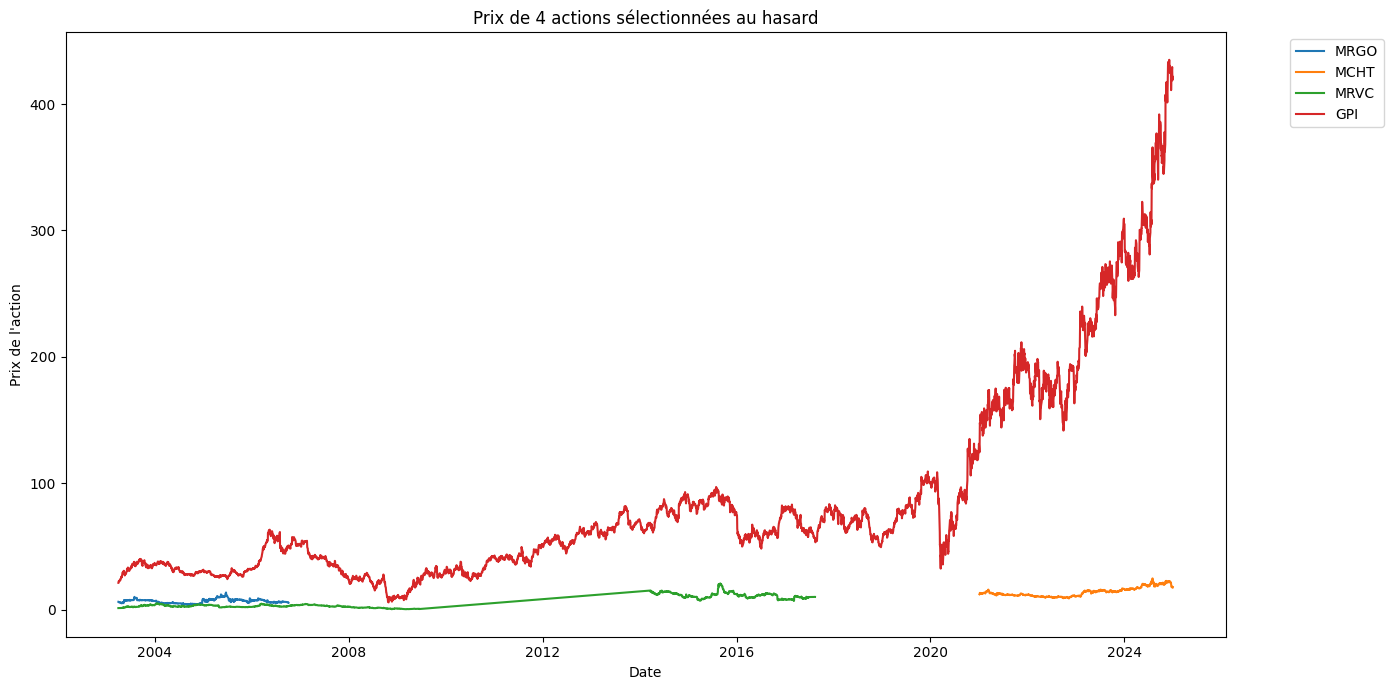

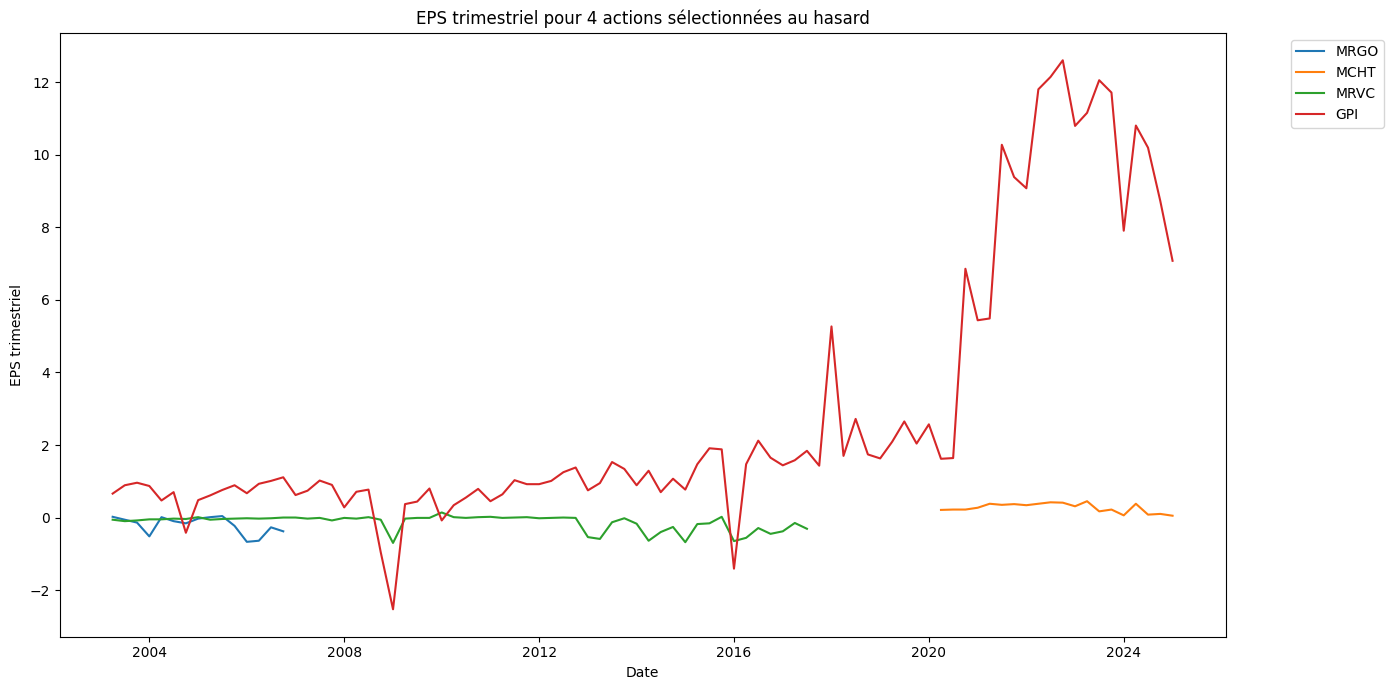

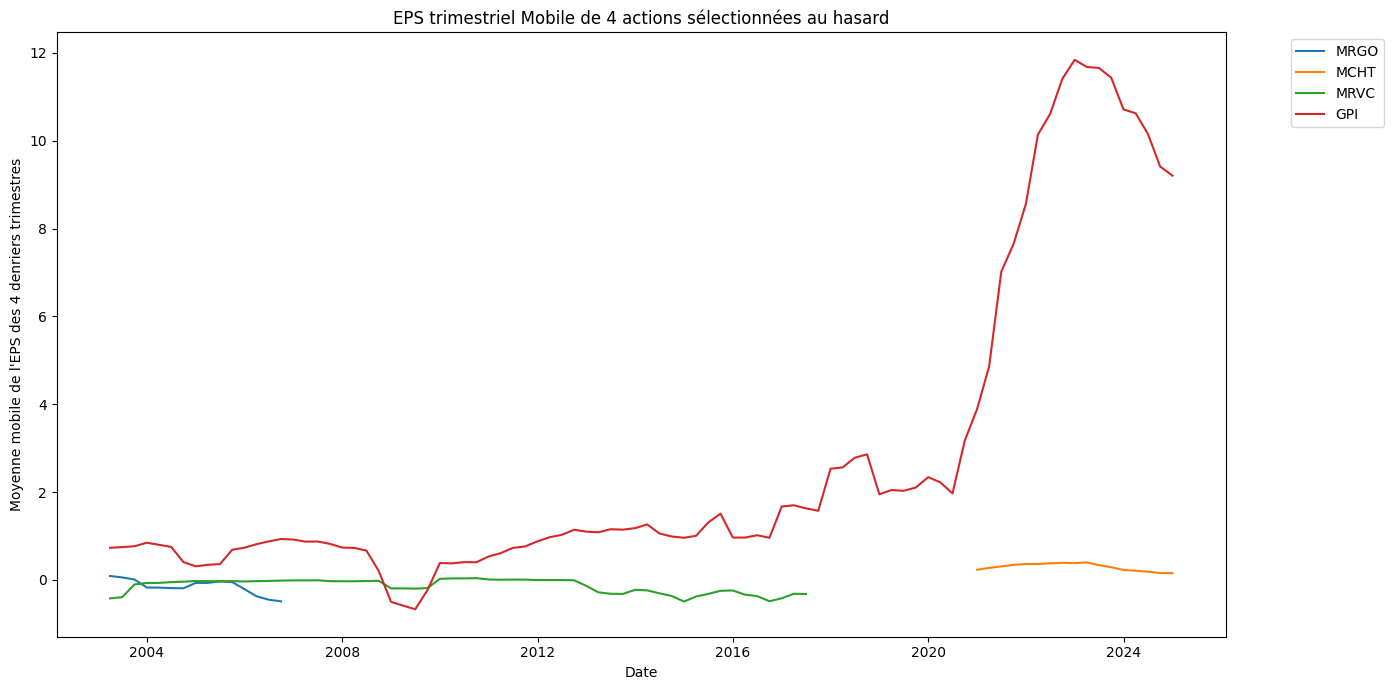

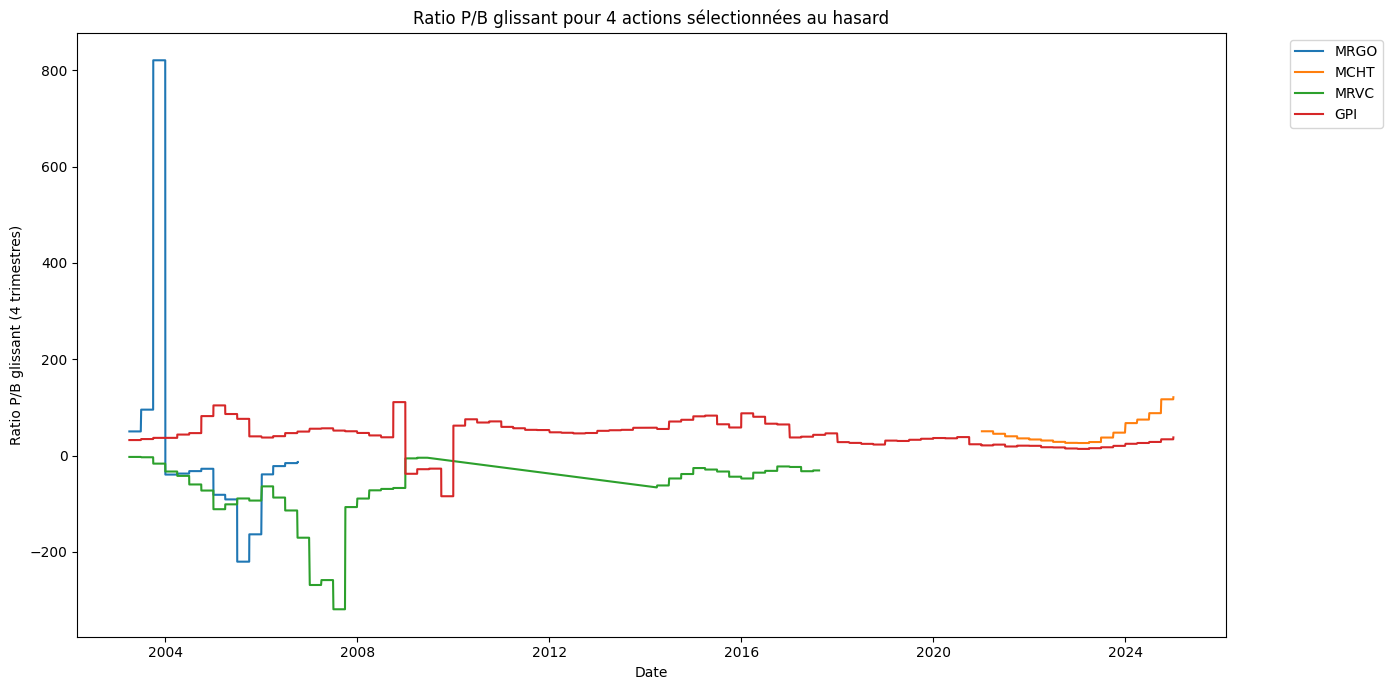

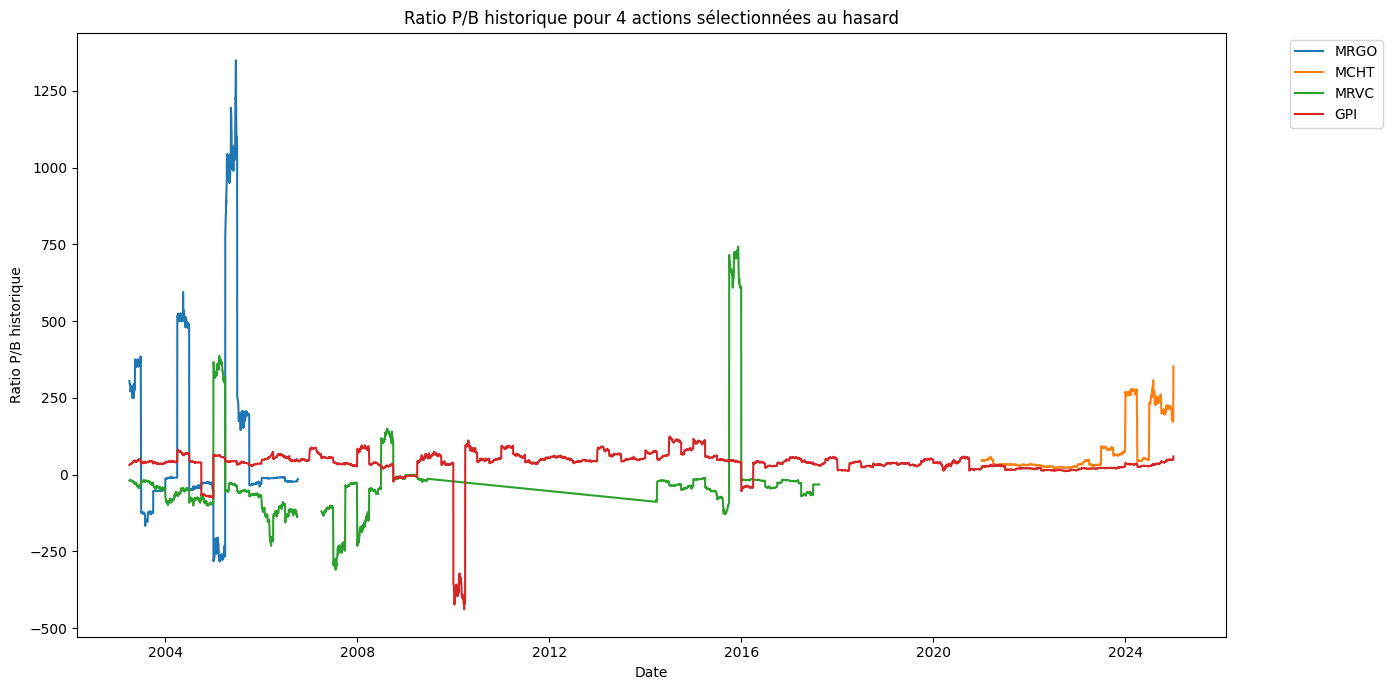

In [55]:
# ajout des rendements 
# Calcul du rendement logarithmique par ticker
df['log_rend'] = df.groupby('ticker')['prix'].transform(lambda x: np.log(x / x.shift(1)))

# supression des NaN restant 
df = df.dropna()

# statistique descriptives des colonnes sélectionnés (par actions)
stat_des = df.groupby("ticker")[['prix', 'EPS', 'ratio_pb_h', 'ratio_pb_MA']].describe()
print(stat_des)

# visualisation des graph de chaque séries 
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(4222)

# Sélectionner 4 tickers au hasard
tickers_unique = df['ticker'].unique()
tickers_alea = np.random.choice(tickers_unique, size=4, replace=False)

# graph de la série avec les prix 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_t = df[df['ticker'] == t]  # filtrer pour ce ticker
    plt.plot(df_t['date'], df_t['prix'], label=t)

plt.xlabel("Date")
plt.ylabel("Prix de l'action")
plt.title("Prix de 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à côté
plt.tight_layout()
plt.show()

# graph pour la série eps trimestriel 
# merge les permno au df quarter afin de pouvoir tracer le graph 
df_quarter = df_quarter.merge(df[['permno', 'ticker']].drop_duplicates(), on='permno', how='left')

plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df_quarter[df_quarter['ticker'] == t]  # filtrer par ticker
    plt.plot(df_q['datadate'], df_q['epspxq'], label=t)

plt.xlabel("Date")
plt.ylabel("EPS trimestriel")
plt.title("EPS trimestriel pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# graph de la série avec les eps mobile 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df_quarter[df_quarter['ticker'] == t]  # filtrer par ticker
    plt.plot(df_q['datadate'], df_q['EPS_MA4'], label=t)

plt.xlabel("Date")
plt.ylabel("Moyenne mobile de l'EPS des 4 denriers trimestres")
plt.title("EPS trimestriel Mobile de 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à côté
plt.tight_layout()
plt.show()

# graph pour le ratio p/b glissant 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df[df['ticker'] == t]
    plt.plot(df_q['date'], df_q['ratio_pb_MA'], label=t)

plt.xlabel("Date")
plt.ylabel("Ratio P/B glissant (4 trimestres)")
plt.title("Ratio P/B glissant pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# graph pour le ratio p/b historique 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df[df['ticker'] == t]
    plt.plot(df_q['date'], df_q['ratio_pb_h'], label=t)

plt.xlabel("Date")
plt.ylabel("Ratio P/B historique")
plt.title("Ratio P/B historique pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [80]:
# régression linéaire avec variable d'intéraction EPS*P/B
import numpy as np
import statsmodels.api as sm

# Créer la variable explicative (d'intéraction)
df["EPS_MA*ratio_pb_MA"] = df["EPS_MA4"] * df["ratio_pb_MA"]

# Remplacer tous les inf par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Supprimer toutes les lignes où X ou Y sont NaN
df_clean = df.dropna(subset=["EPS_MA*ratio_pb_MA", "prix"])

# Forcer les types float64
df_clean["EPS_MA*ratio_pb_MA"] = df_clean["EPS_MA*ratio_pb_MA"].astype(float)
df_clean["prix"] = df_clean["prix"].astype(float)

# Sélectionner X et Y et ajouter la constante
X = sm.add_constant(df_clean[["EPS_MA*ratio_pb_MA"]].astype(float))
Y = df_clean["prix"].astype(float)

# divisions des données en test et entrainement 
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Sélectionner les clusters correspondant à X_train
clusters_train = df_clean.loc[X_train.index, 'permno'].astype(int)

# Vérification finale
print("NaN dans X :", X.isna().sum().sum())
print("NaN dans Y :", Y.isna().sum())
print("inf dans X :", np.isinf(X).sum())
print("inf dans Y :", np.isinf(Y).sum())

# Estimation OLS tranversale 
model_a = sm.OLS(y_train, X_train).fit(cov_type='cluster', cov_kwds={'groups': clusters_train})
print(model_a.summary())

# Estimation 
y_pred_base = model_a.predict(X_test)



NaN dans X : 0
NaN dans Y : 0
inf dans X : const                 0
EPS_MA*ratio_pb_MA    0
dtype: int64
inf dans Y : 0
                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1585.
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           7.27e-27
Time:                        21:15:17   Log-Likelihood:            -1.7295e+05
No. Observations:               48559   AIC:                         3.459e+05
Df Residuals:                   48557   BIC:                         3.459e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
----

In [57]:
# Régression linéaire avec modèle naif 

# supression de potentiels NaN par précaution 
df = df.dropna()

#  --- modèle naif 1 ---  

# définition des variables 
X1 = sm.add_constant(df[["EPS_MA4"]]) # variable indépendante 
Y = df[["prix"]].astype(float) # variable dépendante 
clusters = df["permno"] # groupe 

# modèle (1) 
model_1 = sm.OLS(Y, X1).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# --- modèle naif 2 --- 

# définiton des variables 
X2 = sm.add_constant(df[["ratio_pb_MA"]]) # variable indépendante 
Y = df[["prix"]].astype(float) # variable dépendante 
clusters = df["permno"] # groupe 

# modèle (2) 
model_2 = sm.OLS(Y, X2).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# résultats des deux modèles naif 
print("Résultats modèle naif 1")
print(model_1.summary())
print("---")
print("\n")
print("---")
print("Résultats modèle naif 2")
print(model_2.summary())


Résultats modèle naif 1
                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     74.84
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.59e-09
Time:                        18:15:11   Log-Likelihood:            -2.7146e+05
No. Observations:               60699   AIC:                         5.429e+05
Df Residuals:                   60697   BIC:                         5.429e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.4831      3

Train 46202 lignes, Test 14497 lignes
         prix  pred_model_1  pred_model_2  pred_model_3
17120    54.0     59.810851     32.544229     16.787954
17121  52.985     59.810851     32.544229     16.787954
17122    53.5     59.810851     32.544229     16.787954
17123    53.5     59.810851     32.544229     16.787954
17124   53.95     59.810851     32.544229     16.787954
EQMP Modèle 1 : 210.1975768261911
EQMP Modèle 2 : 1696.9818473060654
EQMP Modèle 3 : 4793.851323025215


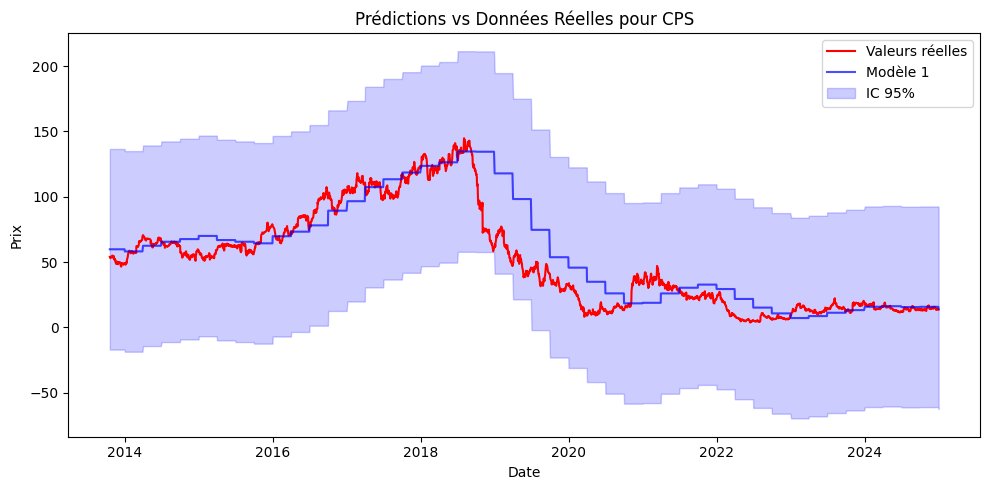

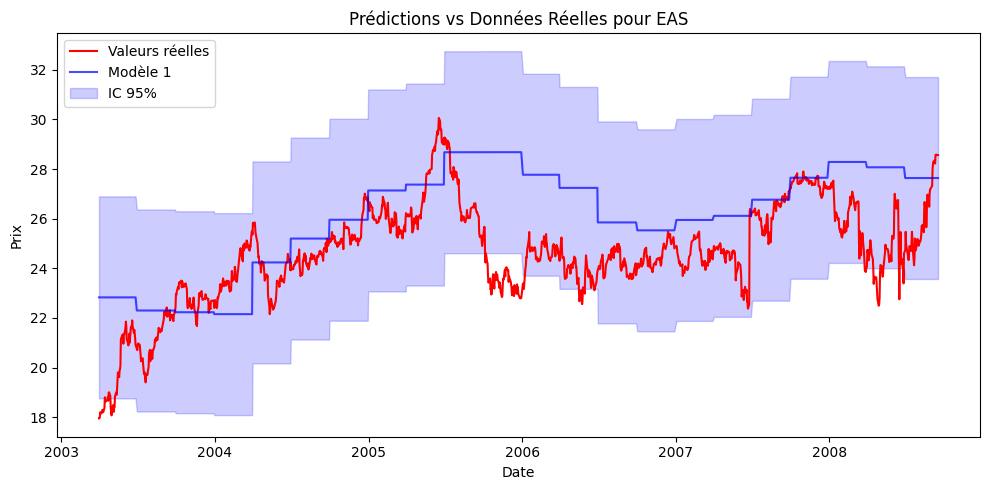

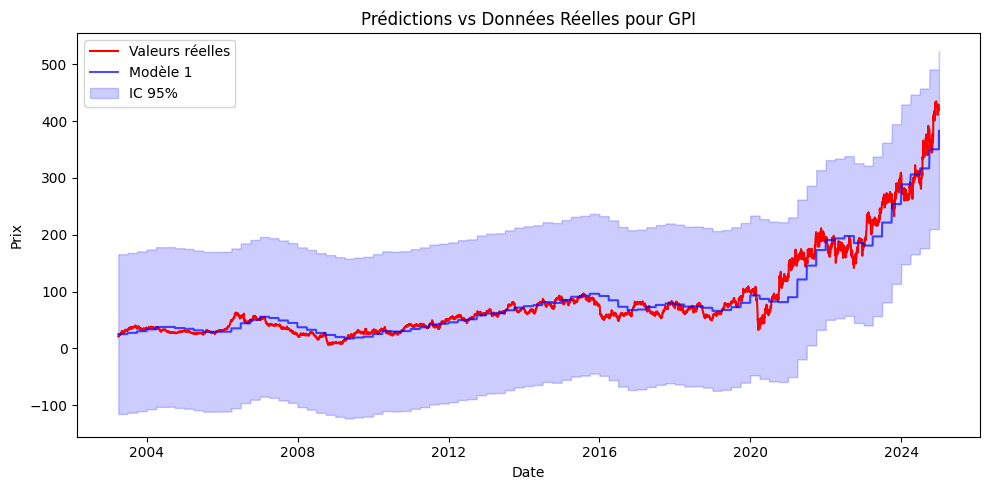

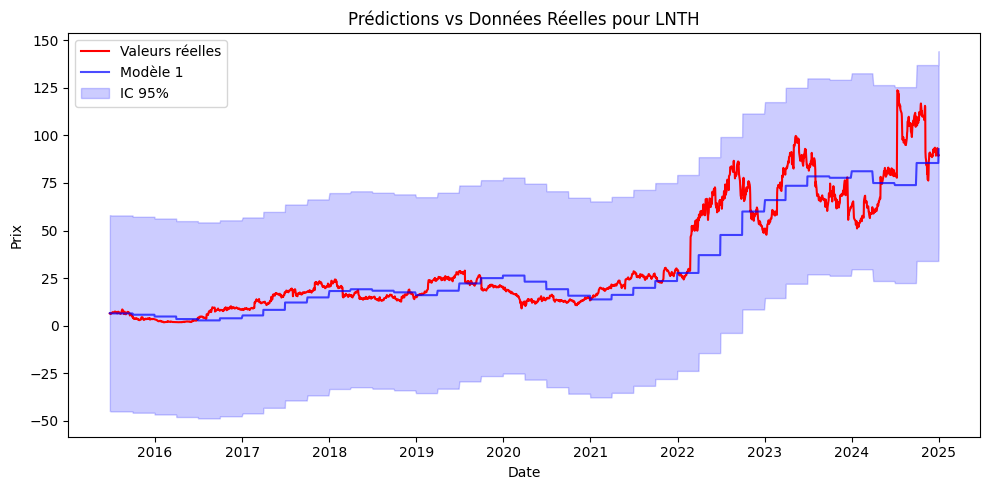

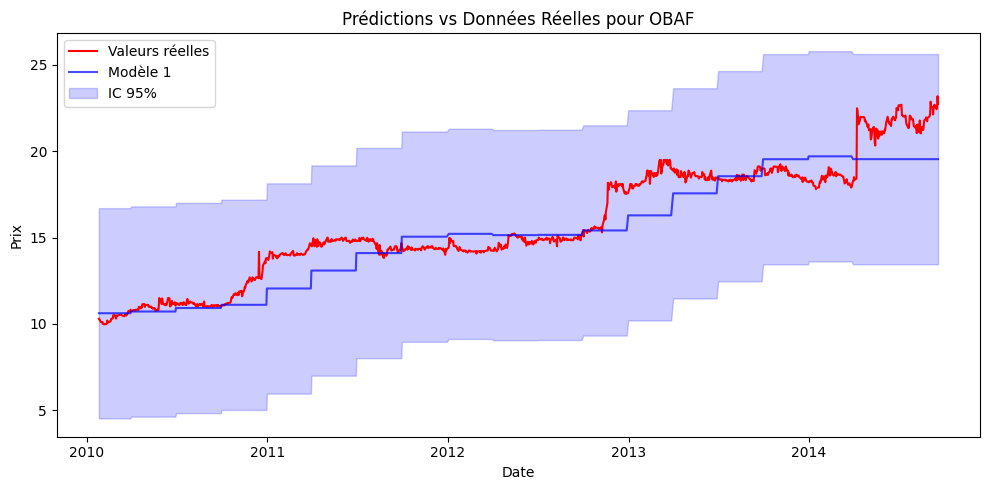

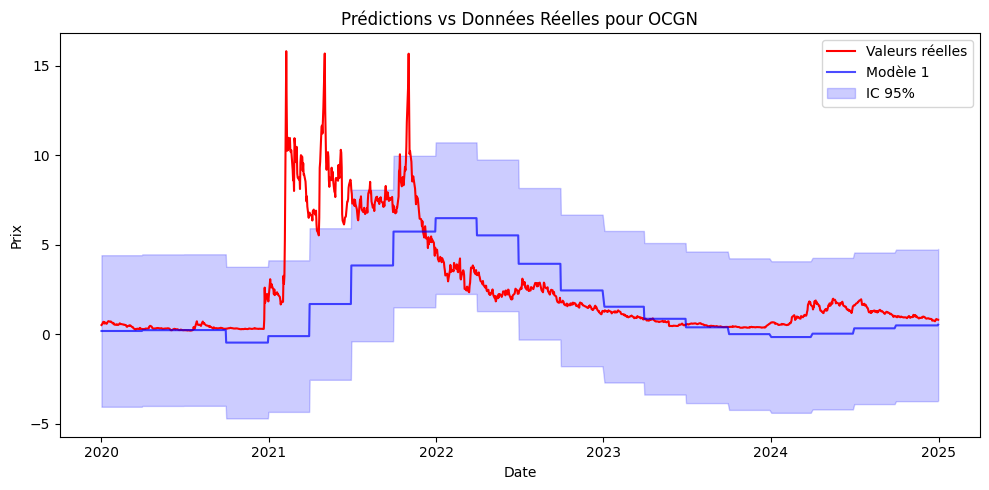

In [58]:
# division des données un deux groupes (entrainement et test)
import numpy as np

tickers = df['ticker'].unique()
np.random.seed(42)

# 80% des tickers pour le train
train_tickers = np.random.choice(tickers, size=int(0.8*len(tickers)), replace=False)
test_tickers = [t for t in tickers if t not in train_tickers]

df_train = df[df['ticker'].isin(train_tickers)]
df_test = df[df['ticker'].isin(test_tickers)]

print(f"Train {len(df_train)} lignes, Test {len(df_test)} lignes")

from sklearn.metrics import mean_squared_error

# fonction permettant de faire des forecast 
def forecast(df_train, df_test): 

    # enlève les potentiels NaN restants 
    df_train = df_train.dropna()
    df_test = df_test.dropna()
    
    # définission des variables indépendantes 
    X1 = sm.add_constant(df_train[["EPS_MA*ratio_pb_MA"]])
    X2 = sm.add_constant(df_train[["EPS_MA4"]])
    X3 = sm.add_constant(df_train[["ratio_pb_MA"]])
    clusters = df_train["permno"] # groupe 

    # définission de la variable dépendantes 
    Y = df_train[["prix"]]

    # estimation des modèles 
    model_1 = sm.OLS(Y, X1).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    model_2 = sm.OLS(Y, X2).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    model_3 = sm.OLS(Y, X3).fit(cov_type='cluster', cov_kwds={'groups': clusters})

    # utilisation des modèles sur les données de test (prévisions)
    # variable de test 
    X1_t = sm.add_constant(df_test[["EPS_MA*ratio_pb_MA"]])
    X2_t = sm.add_constant(df_test[["EPS_MA4"]])
    X3_t = sm.add_constant(df_test[["ratio_pb_MA"]])
    Y_t = df_test[["prix"]] # vrai valeur 
    
    # forcast 
    model_1_pred = model_1.predict(X1_t)
    model_2_pred = model_2.predict(X2_t)
    model_3_pred = model_3.predict(X3_t)

    # résultats 
    df_results = df_test.copy()
    df_results["pred_model_1"] = model_1_pred
    df_results["pred_model_2"] = model_2_pred
    df_results["pred_model_3"] = model_3_pred

    # afficher un extrait
    print(df_results[["prix", "pred_model_1", "pred_model_2", "pred_model_3"]].head())

    # EQMP pour chaque modèle
    eqmp_1 = mean_squared_error(Y_t, model_1_pred)
    eqmp_2 = mean_squared_error(Y_t, model_2_pred)
    eqmp_3 = mean_squared_error(Y_t, model_3_pred)

    print("EQMP Modèle 1 :", eqmp_1)
    print("EQMP Modèle 2 :", eqmp_2)
    print("EQMP Modèle 3 :", eqmp_3)

    return df_results

res = forecast(df_train, df_test)

# graphiques illustrants la différences entre les résultats du forecast et les données réelles 
for ticker in df_test["ticker"].unique():
    df_t = res[res["ticker"] == ticker].sort_values("date")
    
    # calcul IC 95 % pour le modèle 1
    se_pred = res.loc[df_t.index, "pred_model_1"].std()  # approximation de l'erreur standard
    ci_upper = df_t["pred_model_1"] + 1.96 * se_pred
    ci_lower = df_t["pred_model_1"] - 1.96 * se_pred
    
    plt.figure(figsize=(10,5))
    plt.plot(df_t["date"], df_t["prix"], label="Valeurs réelles", color="red")
    plt.plot(df_t["date"], df_t["pred_model_1"], label="Modèle 1", alpha=0.7, color="blue")
    plt.fill_between(df_t["date"], ci_lower, ci_upper, color="blue", alpha=0.2, label="IC 95%")
    
    plt.title(f"Prédictions vs Données Réelles pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- QUESTION 3 --- 

# création de nouvelles varibales indicatrices 

# 1) taux de croissance loga du eps trimestriel 

# tri par ticker et date
df_quarter = df_quarter.sort_values(["ticker", "datadate"])

# calcul du taux de croissance log
df_quarter["log_croissance_eps"] = df_quarter.groupby("ticker")["epspxq"].transform(
    lambda x: np.log(x / x.shift(1))
)

# nettoyage des valeurs infinies et NaN
df_quarter["log_croissance_eps"] = df_quarter["log_croissance_eps"].replace([np.inf, -np.inf], np.nan)
df_quarter["log_croissance_eps"] = df_quarter["log_croissance_eps"].dropna()

# merge 

# trier avant merge_asof
df = df.sort_values(["date"])
df_quarter = df_quarter.sort_values(["datadate"])

df = pd.merge_asof(
    df,
    df_quarter[['permno', 'datadate', 'log_croissance_eps']],
    left_on='date',
    right_on='datadate',
    by='permno',
    direction='backward'
)

# 2) carré du taux de croissance loga du eps trimestriel 
df["log_croissance_eps_2"] = df["log_croissance_eps"] ** 2

# 3) moyenne des prix des 60 dernier jours environ 1 trimestre 
df['prix_MA_200'] = df['prix'].rolling(window=60).mean()

# 4) création d'une variable indicatrice représentant la volatilité 
df_3 = df # changement de nom avant de ne pas modifier le df d'origine 

# Calcul de la volatilité par ticker
df_3['volatility'] = df_3.groupby('ticker')['log_rend'].transform('std')

# Créer la variable binaire "high_vol" (au-dessus de la médiane)
threshold = df_3['volatility'].median()
df_3['high_vol'] = (df_3['volatility'] > threshold).astype(int)

# Vérification rapide
df_3[['ticker', 'volatility', 'high_vol']].drop_duplicates().sort_values(by='volatility', ascending=False)

# nettoyage des données 
df_3 = df_3.dropna() 

c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [81]:
#  --- Régression Ridge --- 
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Colonnes
cols_X = ["log_croissance_eps", "log_croissance_eps_2", "prix_MA_200", "high_vol"]
col_y = "prix"

# Extraire X et y
X = df_3[cols_X]
y = df_3[col_y]

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Liste des alphas à tester
alphas = np.logspace(-3, 3, 50)

# Pipeline : imputation + Standardisation + RidgeCV
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error'))
]) # cv = nb de blocs qu'on test 

# Entraînement
ridge_pipeline.fit(X_train, y_train)

# Accéder au modèle Ridge entraîné et à l'alpha optimal
ridge_model = ridge_pipeline.named_steps['ridge']
print("----- RIDGE -----")
print("Alpha optimal :", ridge_model.alpha_)
print("Coefficients :", ridge_model.coef_)

# Prédictions
y_pred_best = ridge_pipeline.predict(X_test)

# --- Régression Lasso --- 
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas=alphas, cv=5))
])

lasso_pipeline.fit(X_train, y_train)
lasso_model = lasso_pipeline.named_steps['lasso']
print("----- LASSO -----")
print("Alpha optimal :", lasso_model.alpha_)
print("Coefficients :", lasso_model.coef_, "\n")


# --- Régression Elastic net --- 
elastic_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('elastic', ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .9], cv=5))
])

elastic_pipeline.fit(X_train, y_train)
elastic_model = elastic_pipeline.named_steps['elastic']
print("----- Elastic Net -----")
print("Alpha optimal :", elastic_model.alpha_)
print("L1 ratio optimal :", elastic_model.l1_ratio_)
print("Coefficients :", elastic_model.coef_)

# estimation de l'EQMP hors échantillon via fenêtre glissante 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Paramètres de la fenêtre glissante
window_size = 5000  # nombre d'observations utilisées pour entraîner à chaque étape entraine ici 
step = 1000         # décalage de la fenêtre à chaque itération, test sur les 1000 suivantes 

# Stocker les EQMP
rmse_ridge = []
rmse_lasso = []
rmse_elastic = []

# Fenêtre glissante
for start in range(0, len(X) - window_size, step):
    end = start + window_size
    X_train_window = X.iloc[start:end]
    y_train_window = y.iloc[start:end]
    X_test_window = X.iloc[end:end+step]       # prédire les prochaines 'step' observations
    y_test_window = y.iloc[end:end+step]
    
    if len(X_test_window) == 0:
        break
    
    # Entraînement et prédiction Ridge
    ridge_pipeline.fit(X_train_window, y_train_window)
    y_pred_ridge = ridge_pipeline.predict(X_test_window)
    rmse_ridge.append(np.sqrt(mean_squared_error(y_test_window, y_pred_ridge)))
    
    # Entraînement et prédiction Lasso
    lasso_pipeline.fit(X_train_window, y_train_window)
    y_pred_lasso = lasso_pipeline.predict(X_test_window)
    rmse_lasso.append(np.sqrt(mean_squared_error(y_test_window, y_pred_lasso)))
    
    # Entraînement et prédiction Elastic Net
    elastic_pipeline.fit(X_train_window, y_train_window)
    y_pred_elastic = elastic_pipeline.predict(X_test_window)
    rmse_elastic.append(np.sqrt(mean_squared_error(y_test_window, y_pred_elastic)))

# Résultat moyen
print("RMSE moyen Ridge :", np.mean(rmse_ridge))
print("RMSE moyen Lasso :", np.mean(rmse_lasso))
print("RMSE moyen Elastic Net :", np.mean(rmse_elastic))

# test Diebo-Marimo 
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# --- 1. Calcul des erreurs ---
errors_best = (y_test - y_pred_best)**2   # erreur quadratique du meilleur modèle
errors_base = (y_test - y_pred_base)**2   # erreur quadratique du modèle de base

# --- 2. Différence des pertes ---
d = errors_base - errors_best

# --- 3. Statistique DM ---
T = len(d)
mean_d = np.mean(d)
var_d = np.var(d, ddof=1)  # variance empirique
DM_stat = mean_d / np.sqrt(var_d / T)

# p-value pour test bilatéral
p_value = 2 * (1 - stats.norm.cdf(abs(DM_stat)))

print("Statistique DM :", DM_stat)
print("p-value :", p_value)

# --- 4. Interprétation ---
if p_value < 0.05:
    if DM_stat > 0:
        print("Le meilleur modèle est significativement meilleur que le modèle de base.")
    else:
        print("Le meilleur modèle est significativement moins performant que le modèle de base.")
else:
    print("Pas de différence significative entre les modèles.")


----- RIDGE -----
Alpha optimal : 44.98432668969444
Coefficients : [ 0.04191512 -2.41875627 14.18938183 -8.48614825]
----- LASSO -----
Alpha optimal : 0.03906939937054617
Coefficients : [ 1.06244071e-03 -2.38204377e+00  1.41635991e+01 -8.45403475e+00] 

----- Elastic Net -----
Alpha optimal : 0.016768329368110083
L1 ratio optimal : 0.9
Coefficients : [ 0.02591701 -2.40273823 14.16349694 -8.46375217]
RMSE moyen Ridge : 28.199144205393814
RMSE moyen Lasso : 28.214912724927892
RMSE moyen Elastic Net : 28.214687176089782
Statistique DM : -29.691290727689555
p-value : 0.0
Le meilleur modèle est significativement moins performant que le modèle de base.
